# MASTML

In [1]:
import pickle
import numpy as np
import pandas as pd
import itertools
from mastml.mastml import Mastml
from mastml.feature_generators import ElementalFeatureGenerator, ElementalFractionGenerator
import matplotlib.pyplot as plt
import random
from mastml.preprocessing import SklearnPreprocessor
from mastml.feature_selectors import SklearnFeatureSelector, EnsembleModelFeatureSelector
from mastml.models import SklearnModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, ConstantKernel
import time

XGBoost is an optional dependency. If you want to use XGBoost models, please manually install xgboost package with pip install xgboost. If have error with finding libxgboost.dylib library, dobrew install libomp. If do not have brew on your system, first do ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" from the Terminal


## Load Data

In [2]:
pfile_X = "Codes/bandgap_pbe_X.pickle"
pfile_Y = "Codes/bandgap_pbe_Y.pickle"

# LOAD DATA
with open(pfile_X, 'rb') as f:
    data = pickle.load(f)
with open(pfile_Y, 'rb') as f:
    data_y = pickle.load(f)

# PARSE DATA
x_clean = data[['composition', 'structure', 'space group']]
compositions = x_clean['composition']
# structure = x_clean['structure']
print("num compositions", len(compositions))

num compositions 74992


## Functions

In [3]:

def create_subset(sample_from, n = 1000):
    subset_compositions, subset_y = zip(*random.sample(sample_from, n))
    subset_x = pd.DataFrame(subset_compositions)
    return subset_x, subset_y

def vectorize(x_compositions, y):
    e_features = ElementalFeatureGenerator(x_compositions)
    e_features.fit()

    feat_x, feat_y = e_features.transform()

    x = feat_x
    y = subset_y

    # Scale
    preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)
    x = preprocessor.evaluate(X=x, y=y)

    return x, y

def compute_elemetal_fractions(x_compositions):
    e_fraction = ElementalFractionGenerator(x_compositions)
    e_fraction.fit()
    frac_x, frac_y = e_fraction.transform() # only used to create domains later
    return frac_x, frac_y

def featurize(x):
    model = SklearnModel(model='RandomForestRegressor')
    selector = EnsembleModelFeatureSelector(model=model, n_features_to_select=25)
    x = selector.evaluate(X=x, y=y)
    return x

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def showScores(x, y, y_, gpr, std):
    """Show evaluation metrics given `x`, `y`, and predicted y, `y_` and GPR model `gpr`"""
    fig, ax = plt.subplots()
    ax.scatter(x=y, y=y_)
    max_val = max(max(y), max(y_))
    ax.plot([0, max_val], [0, max_val])
    plt.show()

    max_val = max(max(y), max(y_))
    fig, ax = plt.subplots()
    ax.scatter(x=y, y=y_)
    ax.set_xlim((0, max_val))
    ax.set_ylim((0, max_val))
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.show()

    r2_score = gpr.score(x, y)
    print(f"R^2 score: {r2_score}")
    err = rmse(y, y_) / np.std(y)
    print(f"R^2 score / std: {err}")

    plt.hist(std)
    plt.show()

def fit_gpr(x, y):
    """Given `x` and `y` returns a trained GPR model"""
    gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)

    print("Start fitting")
    stime = time.time()

    gpr.fit(x, y)

    print("Done. Time for GPR fitting: %.3f" % (time.time() - stime))
    return gpr

## One Run

In [4]:
# subset n random values
comp_zip_y = list(zip(compositions, data_y.T.values.tolist()[0]))

subset_x, subset_y = create_subset(comp_zip_y, n=1000)

In [5]:
# Vectorize
x, y = vectorize(subset_x, subset_y)

# check that the y is reasonable
# plt.hist(y)
# plt.show()

Dropping 5/440 generated columns due to missing values


In [6]:
# Featurize
x = featurize(x)

In [7]:
## Fit GPR

gpr = fit_gpr(x, y)

Start fitting
Done. Time for GPR fitting: 48.211


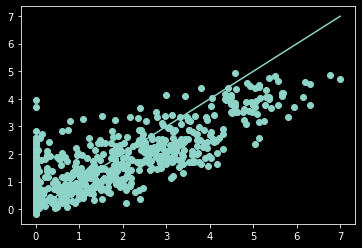

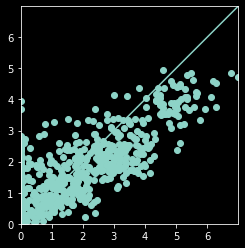

R^2 score: 0.6955404761481518
R^2 score / std: 0.5517785097771098


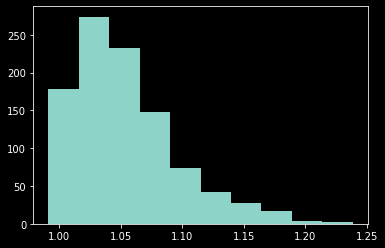

In [8]:
## Predict and score for all

y_, std_ = gpr.predict(x, return_std=True)
showScores(x, y, y_, gpr, std_)

# _ = plt.hist(std_)
# plt.show()

In [9]:
# Compute domain assesment
# Split x and y by domains using frac_x

frac_x, _ = compute_elemetal_fractions(subset_x)
# frac_x, _ = compute_elemetal_fractions(compositions)

element = "O"
threshold = 0
subset_y_df = pd.DataFrame(subset_y)
g1 = frac_x[frac_x[element] <= threshold]
g1_y = subset_y_df[frac_x[element] <= threshold]
g2 = frac_x[frac_x[element] > threshold]
g2_y = subset_y_df[frac_x[element] > threshold]

print(len(g1))
print(len(g2))

524
476


In [10]:

# TODO: create code to do gpr comparison between domains

# gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
# gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)

# print("Start fitting")
# stime = time.time()

# gpr.fit(x, y)

# print("Done. Time for GPR fitting: %.3f" % (time.time() - stime))

# y_, std_ = gpr2.predict(g1, return_std=True)
# showScores(g1, g1_y, y_, gpr2)

## Run to test domains

In [11]:
# create subsets such that there is enough training (at least 500)
subset_x = subset_y = g1 = g2 = g1_y = g2_y = frac_x = None
n = 2000
element = "O"
threshold = 0

for i in range(1000):
    # create subset
    subset_x, subset_y = create_subset(comp_zip_y, n=n)
    # from subset create domains
    frac_x, _ = compute_elemetal_fractions(subset_x)
    g1 = frac_x[frac_x[element] <= threshold]

    if len(g1) > 500:
        break
    n *= 1.1
    n = int(n)

# Vectorize
x, y = vectorize(subset_x, subset_y)

# Featurize
x = featurize(x)

Dropping 5/440 generated columns due to missing values


In [12]:
# create groups
subset_y_df = pd.DataFrame(subset_y)
g1 = x[frac_x[element] <= threshold]
g1_y = subset_y_df[frac_x[element] <= threshold]
g2 = x[frac_x[element] > threshold]
g2_y = subset_y_df[frac_x[element] > threshold]

# train GPR on in-domain

gpr_domain = fit_gpr(g1, g1_y)

# test on in-domain, out-domain, all

y_in, std_in = gpr_domain.predict(g1, return_std=True) # in-domain
y_out, std_out = gpr_domain.predict(g2, return_std=True) # out-domain
y_all, std_all = gpr_domain.predict(x, return_std=True) # all

# TODO: Test for different materials, thresholds, kernels, etc.

Start fitting
Done. Time for GPR fitting: 40.670


/Users/averychan/opt/anaconda3/envs/MAST_ML_env/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


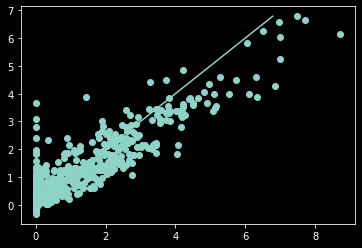

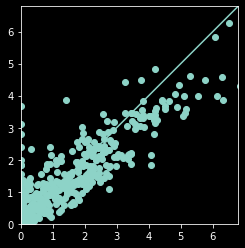

R^2 score: 0.8527785306132563
R^2 score / std: 0    0.383695
dtype: float64


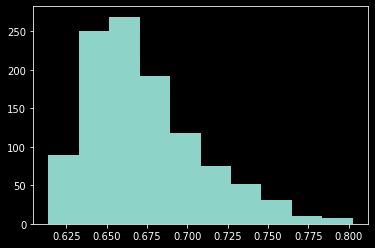

In [13]:
# in-domain
showScores(g1, g1_y, y_in, gpr_domain, std_in)

/Users/averychan/opt/anaconda3/envs/MAST_ML_env/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


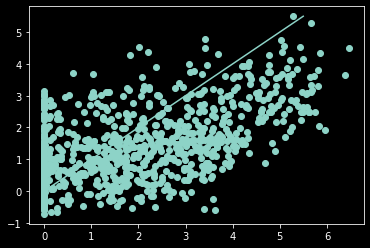

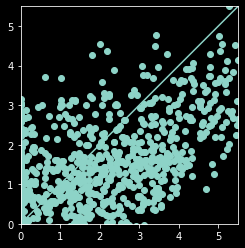

R^2 score: 0.20463918400727032
R^2 score / std: 0    0.89183
dtype: float64


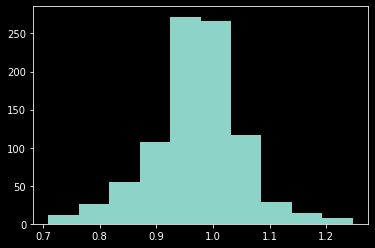

In [14]:
# out-domain
showScores(g2, g2_y, y_out, gpr_domain, std_out)

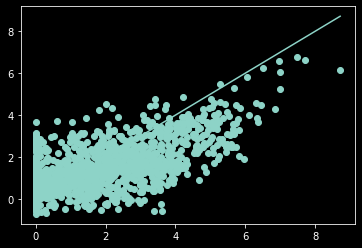

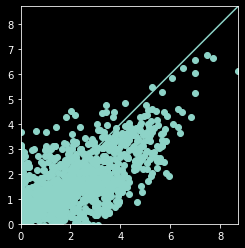

R^2 score: 0.5542551046846688
R^2 score / std: 1.2473240808783916


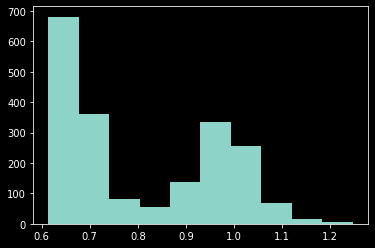

In [15]:
# all
showScores(x, y, y_all, gpr_domain, std_all)

## OLD CODE

In [16]:
# list(x.items())
# print(*x.items(), sep="\n")
# print(x.iloc[0])

## verify rows sum to 1
# total = x.sum(axis=1, numeric_only= True)
# print("total", total)

# material_group_char = ["O", "B", "F", "Cl", "Br", "I"]
material_group_char = ["O"]
thresholds = [0]
for mat in material_group_char:
    continue
    print("Grouping for", mat)
    st1 = 100
    st2 = 10

    for th in thresholds:
        # Make split
        group_X = x[x[mat] > th]
        not_group_X = x[x[mat] <= th]
        # group_y = [None for x in group_X]
        # not_group_y = [None for x in not_group_y]
        group_y = y[x[mat] > th]
        not_group_y = y[x[mat] <= th]

        perc_in_group = group_X.shape[0]/x.shape[0]
        print(f"\ttheshold:\t{th}\n\tpercent in {mat}_group:\t{perc_in_group}")
        # if the split leaves an empty group skip
        if perc_in_group == 0:
            continue

        # group_X.iloc(100)
        group_X = np.array(group_X)
        group_y = np.array(group_y)

        group_X = group_X[0:1000,:]
        group_y = group_y[0:1000,:]
        
        # do GPR stuff
        print(f"Doing GPR for {mat}")
        # gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1) 
        gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
        gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)
        print("gpr:", gpr)
        # break
        stime = time.time()
        print("Start fitting")
        # gpr.fit(group_X, group_y)
        print("Time for GPR fitting: %.3f" % (time.time() - stime))
        print("Done")

        x_, std_ = gpr.predict(group_X, return_std=True)
        print("x_", x_)
        print("std_", std_)

        # Predict using gaussian process regressor
        # stime = time.time()
        # y_gpr = gpr.predict(X_plot, return_std=False)
        # print("Time for GPR prediction: %.3f" % (time.time() - stime))

# gpr.kernel_
# np.std(group_X)